<a href="https://colab.research.google.com/github/meidytarully/UAS_Data_Mining/blob/main/UAS_Data_Mining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [218]:
import numpy as np
import pandas as pd
import os
import spacy
import en_core_web_sm
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
!pip install vaderSentiment
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [219]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [220]:
# preprocessing the data file
#  read the data
df1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebook/drugsComTrain_raw.tsv",sep='\t')
df2 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebook/drugsComTest_raw.tsv",sep='\t')
# combine two file
df = pd.concat([df1, df2])
df
# rename the cols
df.columns = ['ID','drug name','condition','review','rating','date','useful count']

In [221]:
print(df1.shape)
print(df2.shape)
print(df.shape)

(161297, 7)
(53766, 7)
(215063, 7)


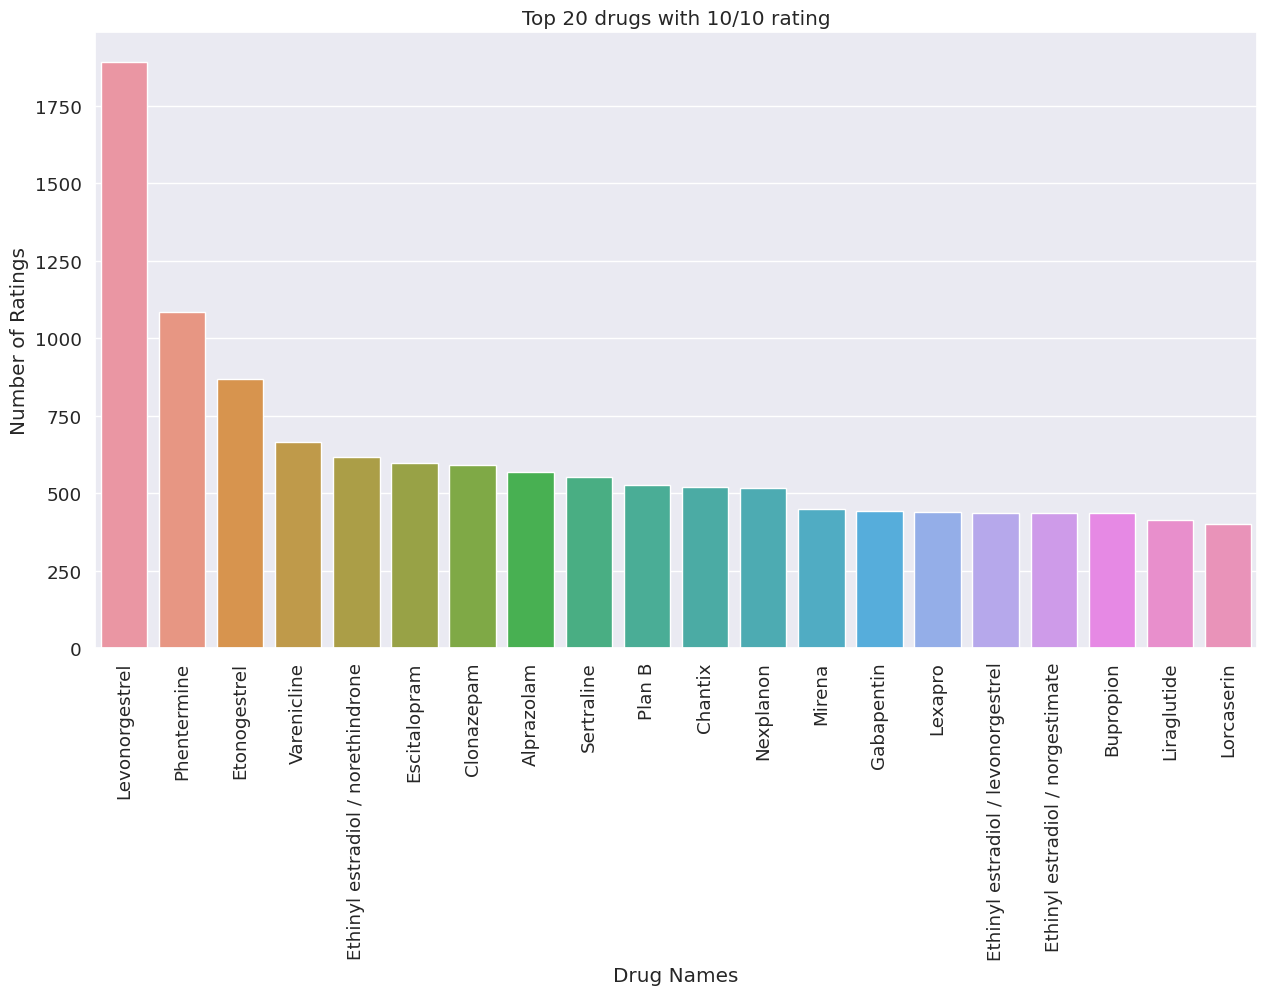

In [222]:
import seaborn as sns
#!pip install matplotlib
import matplotlib.pyplot as plt

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 10, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

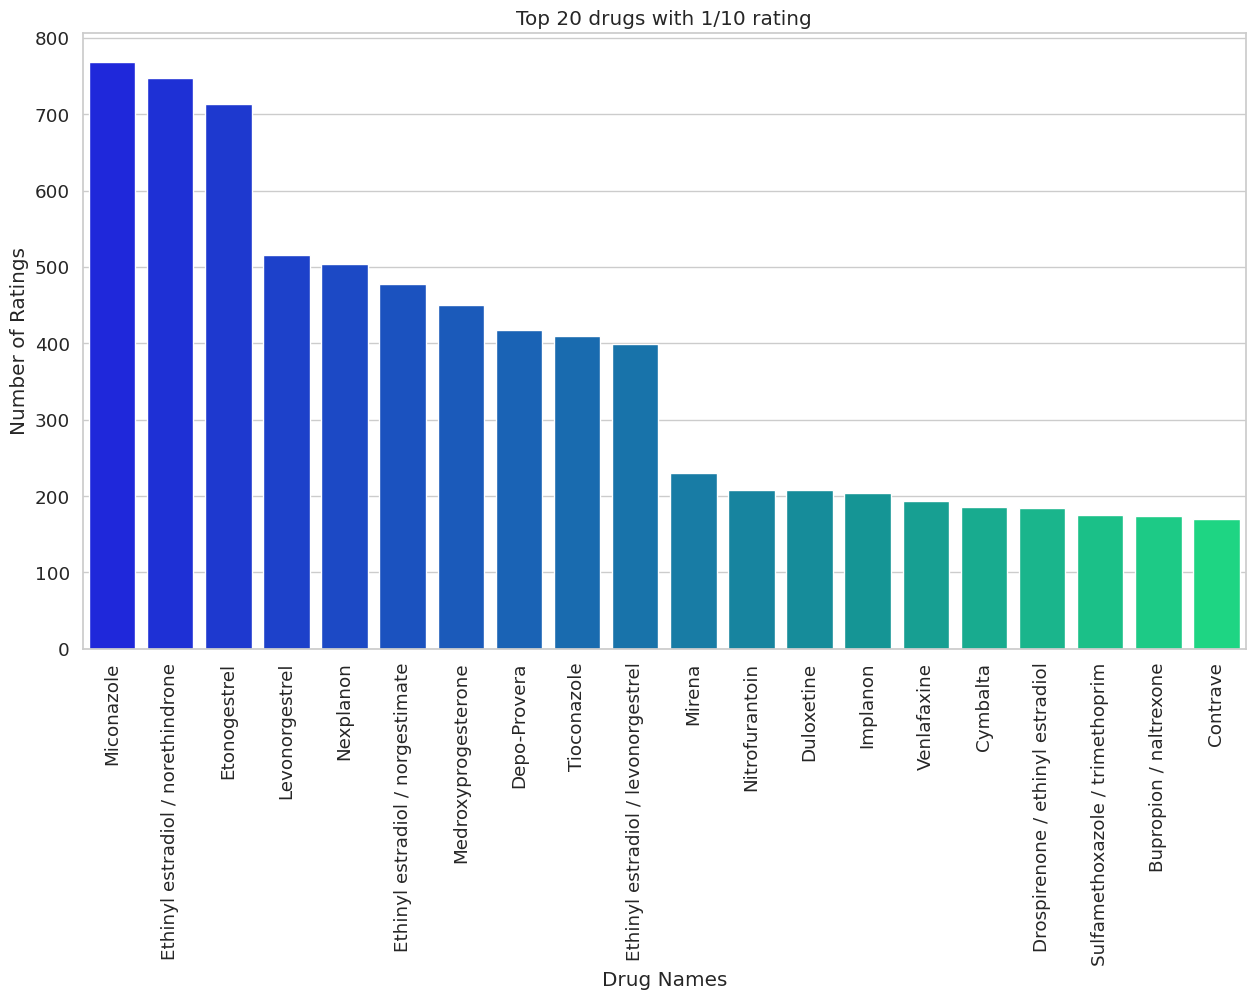

In [223]:
# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 1, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

In [224]:
df

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


In [225]:
df.columns

Index(['ID', 'drug name', 'condition', 'review', 'rating', 'date',
       'useful count'],
      dtype='object')

<ipython-input-226-ca76ccecdffc>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_2 = sns.distplot(df['rating'], ax = ax[1])


Text(0.5, 0, 'Rating')

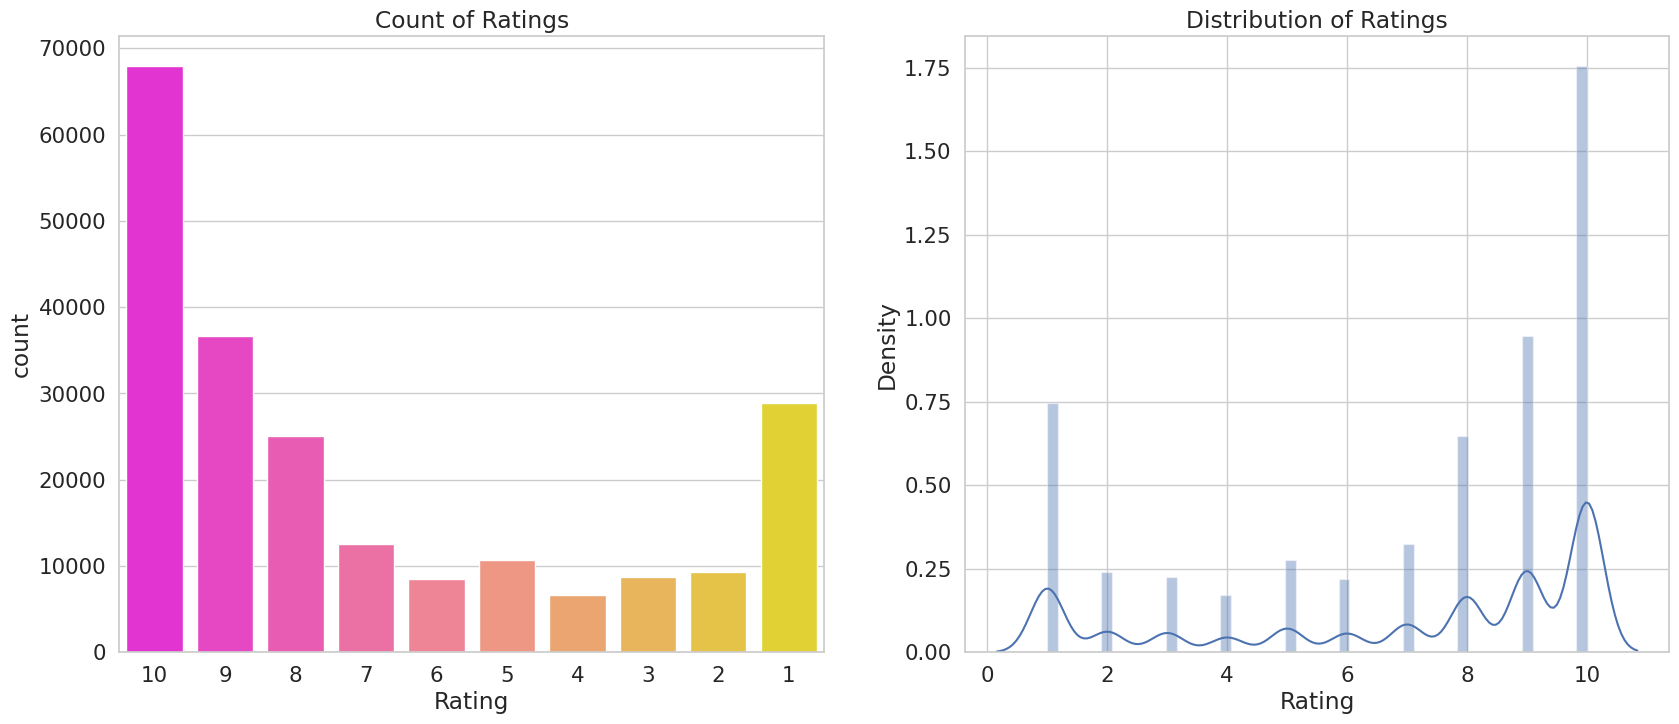

In [226]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)
sns_1 = sns.countplot(x='rating', data=df, palette='spring', order=list(range(10, 0, -1)), ax=ax[0])
sns_2 = sns.distplot(df['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating")

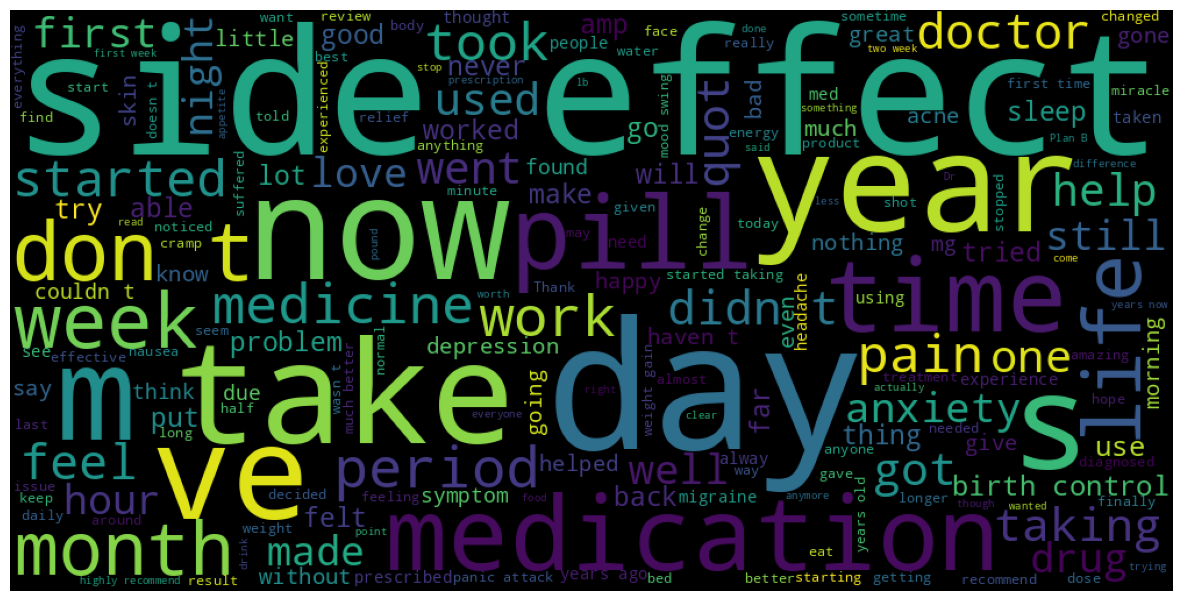

In [227]:
#!pip install wordcloud
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 10
df_rate_ten = df.loc[df.rating == 10, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

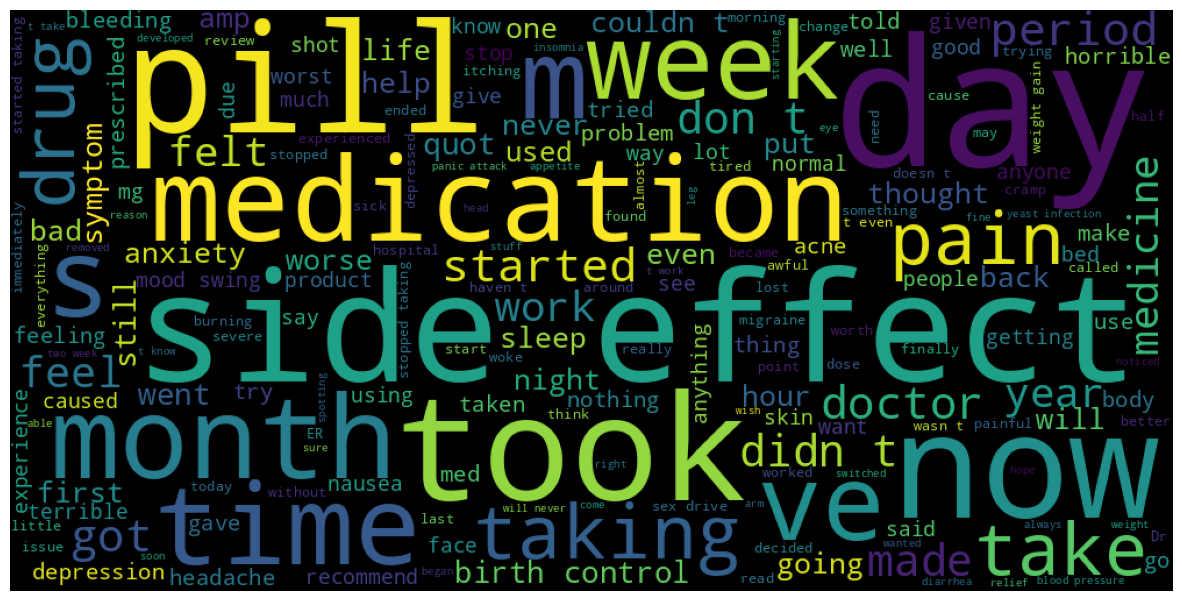

In [228]:
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 1
df_rate_ten = df.loc[df.rating == 1, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

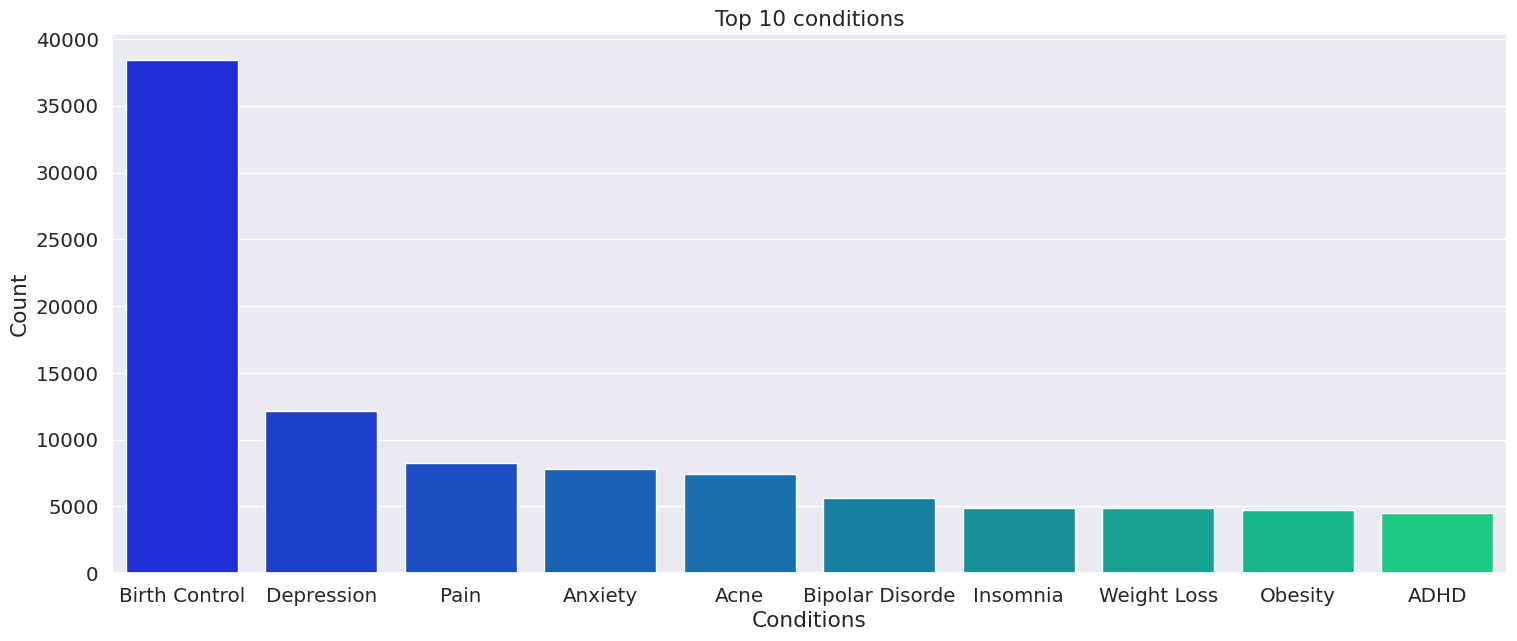

In [229]:
# This barplot show the top 10 conditions the people are suffering.
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

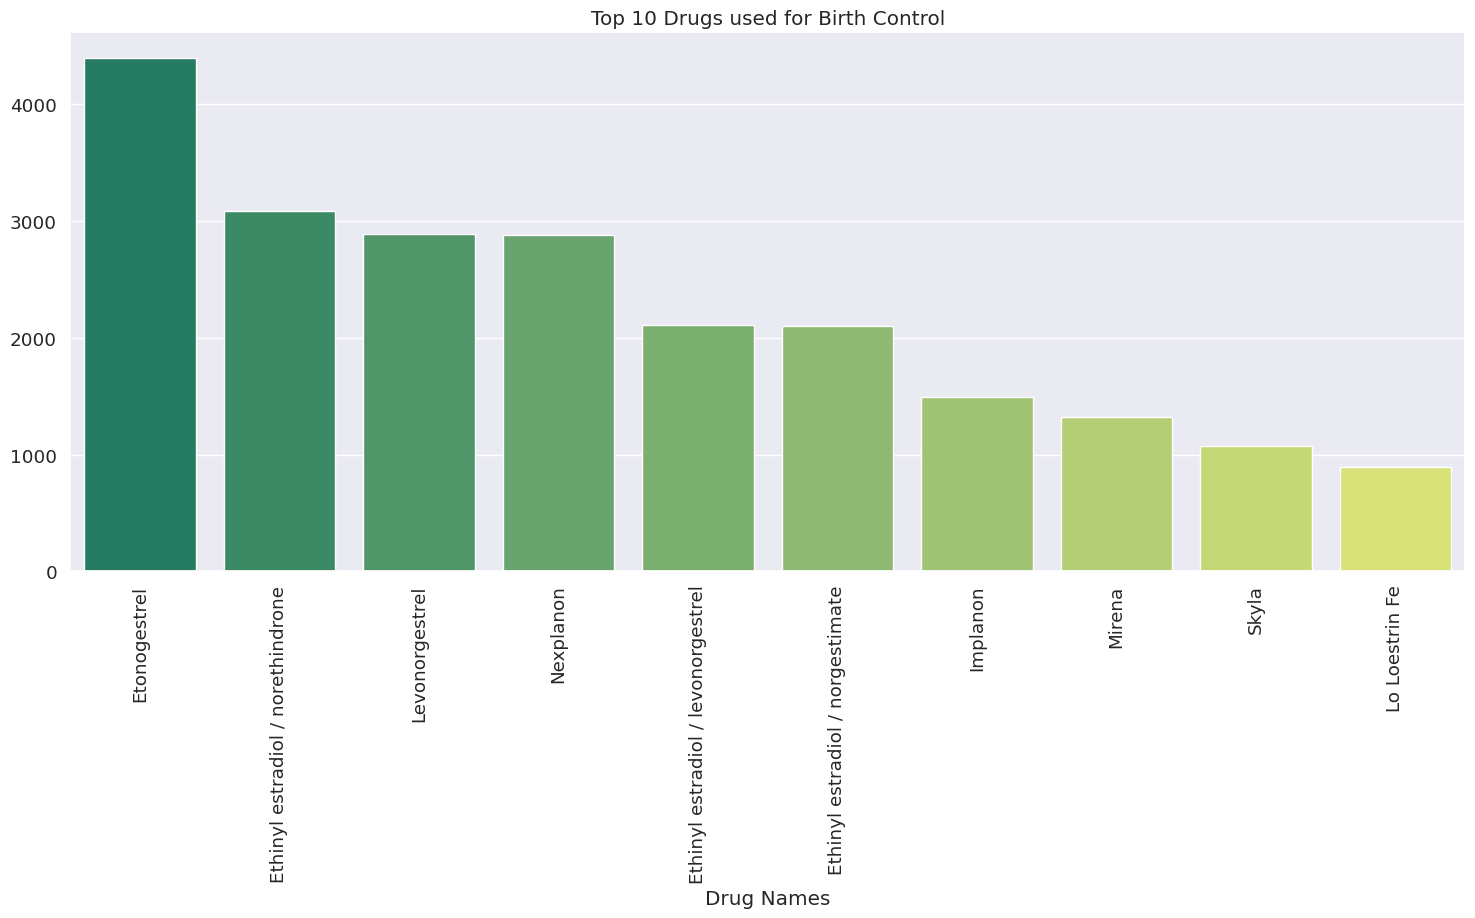

In [230]:
# Top 10 drugs which are used for the top condition, that is Birth Control
df_cond_birth = df[df['condition'] == 'Birth Control']['drug name'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df_cond_birth.index, y = df_cond_birth.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);

In [231]:
df

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10.0,"September 13, 2014",43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9.0,"October 8, 2016",11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8.0,"November 15, 2010",7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1.0,"November 28, 2011",20


In [232]:
df2 = df[df['useful count'] > 10]

In [233]:
df_condition = df2.groupby(['condition'])['drug name'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drug name
706,64</span> users found this comment helpful.,1
707,92</span> users found this comment helpful.,1
708,Gastritis/Duodenitis,1
709,Esophageal Variceal Hemorrhage Prophylaxis,1
710,98</span> users found this comment helpful.,1
711,Severe Mood Dysregulation,1
712,Short Stature,1
713,Short Stature for Age,1
714,Meningitis,1
715,"Skin Disinfection, Preoperative",1


In [234]:
df_condition_1 = df_condition[df_condition['drug name'] == 1].reset_index()

all_list = set(df.index)

# deleting them
condition_list = []
for i,j in enumerate(df['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)

new_idx = all_list.difference(set(condition_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [235]:
df.shape

(160684, 7)

In [236]:
# removing the conditions with <span> in it.

all_list = set(df.index)
span_list = []
for i,j in enumerate(df['condition']):
    if "</span>" in str(j):
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [237]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [238]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [239]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

# create a list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()
punctuations = string.punctuation
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens


In [240]:
%time df['review_clean'] = df['review'].apply(review_to_words)
df.head()

<ipython-input-239-950f048331b1>:5: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review_text = BeautifulSoup(raw_review, 'html.parser').get_text()


CPU times: user 2min 8s, sys: 117 ms, total: 2min 8s
Wall time: 2min 9s


,ID,drug name,condition,review,rating,date,useful count,review_clean
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,no side effect take combin bystol mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv becam concern ...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,use take anoth oral contracept pill cycl happi...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time use form birth control glad went pa...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxon complet turn life around feel healthie...


In [241]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
#  tf-idf vector
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [242]:
# part 1---vader sentiment analyzer for c_review
analyzer = SentimentIntensityAnalyzer()
# create new col vaderReviewScore based on C-review
df['vaderReviewScore'] = df['review_clean'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# define the positive, neutral and negative
positive_num = len(df[df['vaderReviewScore'] >=0.05])
neutral_num = len(df[(df['vaderReviewScore'] >-0.05) & (df['vaderReviewScore']<0.05)])
negative_num = len(df[df['vaderReviewScore']<=-0.05])

# create new col vaderSentiment based on vaderReviewScore
df['vaderSentiment'] = df['vaderReviewScore'].map(lambda x:int(2) if x>=0.05 else int(1) if x<=-0.05 else int(0) )
df['vaderSentiment'].value_counts() # 2-pos: 99519; 1-neg: 104434; 0-neu: 11110

# label pos/neg/neu based on vaderSentiment result
df.loc[df['vaderReviewScore'] >=0.05,"vaderSentimentLabel"] ="positive"
df.loc[(df['vaderReviewScore'] >-0.05) & (df['vaderReviewScore']<0.05),"vaderSentimentLabel"]= "neutral"
df.loc[df['vaderReviewScore']<=-0.05,"vaderSentimentLabel"] = "negative"

In [243]:
df['vaderReviewScore'].max()

0.9935

In [244]:
df['vaderReviewScore'].min()

-0.9973

In [245]:
#Normalizing "vaderReviewScore"
criteria = [df['vaderReviewScore'].between(-0.997, -0.799), df['vaderReviewScore'].between(-0.798, -0.601), df['vaderReviewScore'].between(-0.600, 0.403), df['vaderReviewScore'].between(-0.402, -0.205), df['vaderReviewScore'].between(-0.204, -0.007), df['vaderReviewScore'].between(-0.006,0.191), df['vaderReviewScore'].between(0.192, 0.389), df['vaderReviewScore'].between(0.390, 0.587), df['vaderReviewScore'].between(0.588, 0.785), df['vaderReviewScore'].between(0.786, 1)]
values = [1, 2, 3,4,5,6,7,8,9,10]

df['normalVaderScore'] = np.select(criteria, values, 0)

In [246]:
df

,ID,drug name,condition,review,rating,date,useful count,review_clean,vaderReviewScore,vaderSentiment,vaderSentimentLabel,normalVaderScore
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,no side effect take combin bystol mg fish oil,-0.2960,1,negative,3
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv becam concern ...,0.6929,2,positive,9
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,use take anoth oral contracept pill cycl happi...,0.2732,2,positive,3
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time use form birth control glad went pa...,0.4199,2,positive,8
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxon complet turn life around feel healthie...,0.8934,2,positive,10
...,...,...,...,...,...,...,...,...,...,...,...,...
159803,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10.0,"May 31, 2015",125,wrote first report mid octob not alcohol sinc ...,0.9362,2,positive,10
159804,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1.0,"November 1, 2011",34,given iv surgey immedi becam anxious could not...,-0.2732,1,negative,3
159805,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2.0,"March 15, 2014",35,limit improv month develop bad rash md refus c...,-0.7351,1,negative,2
159806,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10.0,"September 19, 2015",79,thyroid medic year spent first synthroid vario...,0.7655,2,positive,9


In [247]:
#Final Normalized Score combining Rating and normalVaderScore
df['meanNormalizedScore'] = (df['rating'] + df['normalVaderScore'])/2
df.head()

,ID,drug name,condition,review,rating,date,useful count,review_clean,vaderReviewScore,vaderSentiment,vaderSentimentLabel,normalVaderScore,meanNormalizedScore
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,no side effect take combin bystol mg fish oil,-0.2960,1,negative,3,6.0
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,son halfway fourth week intuniv becam concern ...,0.6929,2,positive,9,8.5
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,use take anoth oral contracept pill cycl happi...,0.2732,2,positive,3,4.0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,first time use form birth control glad went pa...,0.4199,2,positive,8,8.0
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,suboxon complet turn life around feel healthie...,0.8934,2,positive,10,9.5


In [248]:
#Sorting Data based on Condition and then by drug
grouped = df.groupby(['condition','drug name']).agg({'meanNormalizedScore' : ['mean']})
grouped.to_csv('Grouped_Drug_Recommendation_Normalized')
grouped.head(10)

meanNormalizedScore
                                                         mean
condition drug name                                          
ADHD      Adderall                                   6.990625
          Adderall XR                                7.172897
          Adzenys XR-ODT                             6.805556
          Amantadine                                 5.666667
          Amphetamine                                6.522727
          Amphetamine / dextroamphetamine            6.941926
          Aptensio XR                                5.833333
          Armodafinil                                6.937500
          Atomoxetine                                5.182266
          Bupropion                                  6.879310

In [249]:
#Verification using Machine Learning Models
from sklearn.model_selection import train_test_split

x_train, x_test = train_test_split(df, test_size = 0.25, random_state = 0)

In [250]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

cv = CountVectorizer(max_features = 20000, ngram_range = (4, 4))
pipeline = Pipeline([('vect',cv)])

x_train_features = pipeline.fit_transform(x_train['review_clean'])
x_test_features = pipeline.fit_transform(x_test['review_clean'])

print("x_train_features :", x_train_features.shape)
print("x_test_features :", x_test_features.shape)
# let's make a new column review sentiment

df.loc[(df['rating'] >= 5), 'Review_Sentiment'] = 1
df.loc[(df['rating'] < 5), 'Review_Sentiment'] = 0

df['Review_Sentiment'].value_counts()

x_train_features : (119856, 20000)
x_test_features : (39952, 20000)


1.0    120085
0.0     39723
Name: Review_Sentiment, dtype: int64

In [251]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from mlxtend.classifier import StackingClassifier
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import precision_score, confusion_matrix, recall_score
from sklearn.metrics import classification_report
# making our dependent variable



features = df['review_clean'] # the features we want to analyze
labels = df['Review_Sentiment'] # the labels, we want to test against
X_train, X_test, y_train, y_test= train_test_split(features, labels, test_size=0.2, random_state=0)

clf2 = LogisticRegression(random_state=0,solver='lbfgs',max_iter=2000,multi_class='auto')
#clf3 = SVC(kernel="linear", C=5)
clf7 = SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=10, tol=None)

In [267]:
#LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Create a CountVectorizer for text feature extraction
vectorizer = CountVectorizer()

# Fit the vectorizer on the training data and transform the data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

# Create a Logistic Regression classifier
logreg = LogisticRegression()

# Fit the classifier on the vectorized training data and corresponding labels
logreg.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_logreg = logreg.predict(X_test_vec)

# Calculate the accuracy score
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
print("Log Reg: ", logreg_accuracy)


Log Reg:  0.8410925474000376


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [265]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtain the predicted probabilities for the positive class
y_score = logreg.predict_proba(X_test_vec)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

In [254]:
#Classification Report
target_names = ["class 1", "class 2"]
print(classification_report(y_test, y_pred_logreg,target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.72      0.58      0.64      7920
     class 2       0.87      0.93      0.90     24042

    accuracy                           0.84     31962
   macro avg       0.80      0.75      0.77     31962
weighted avg       0.83      0.84      0.83     31962



In [255]:
#Confusion Matrix
cm2 = confusion_matrix(y_pred=y_pred_logreg, y_true=y_test)
cm2

array([[ 4580,  3340],
       [ 1739, 22303]])

In [256]:
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.8816562177805003


In [257]:
#SGD

# Fit the vectorizer on the training data and transform the data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

# Create a SGD classifier
SGDC = SGDClassifier(loss='log')

# Fit the classifier on the vectorized training data and corresponding labels
SGDC.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_SGD = SGDC.predict(X_test_vec)

# Calculate the accuracy score
SGDC_accuracy = accuracy_score(y_test, y_pred_SGD)
print("SGD Classification: ", SGDC_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


SGD Classification:  0.8377761091295914


In [266]:
# Obtain the predicted probabilities for the positive class
y_score_SGD = SGDC.predict_proba(X_test_vec)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

In [259]:
#Classification Report
target_names = ["class 1", "class 2"]
print(classification_report(y_test, y_pred_SGD,target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.73      0.54      0.62      7920
     class 2       0.86      0.93      0.90     24042

    accuracy                           0.84     31962
   macro avg       0.80      0.74      0.76     31962
weighted avg       0.83      0.84      0.83     31962



In [260]:
#Confusion Matrix
cm3 = confusion_matrix(y_pred=y_pred_SGD, y_true=y_test)
cm3

array([[ 4303,  3617],
       [ 1568, 22474]])

In [261]:
#MultinomialNB

# Fit the vectorizer on the training data and transform the data
X_train_vec = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_vec = vectorizer.transform(X_test)

# Create a Multinomial Naive Bayes classifier
MultiNB = MultinomialNB()

# Fit the classifier on the vectorized training data and corresponding labels
MultiNB.fit(X_train_vec, y_train)

# Make predictions on the test data
y_pred_MultiNB = MultiNB.predict(X_test_vec)

# Calculate the accuracy score
MultiNB_accuracy = accuracy_score(y_test, y_pred_MultiNB)
print("MultinomialNB: ", MultiNB_accuracy)

MultinomialNB:  0.812370940491834


In [262]:
# Obtain the predicted probabilities for the positive class
y_score_MultiNB = MultiNB.predict_proba(X_test_vec)[:, 1]

# Calculate the false positive rate, true positive rate, and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_score)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)

In [263]:
#Classification Report
target_names = ["class 1", "class 2"]
print(classification_report(y_test, y_pred_MultiNB,target_names=target_names))

              precision    recall  f1-score   support

     class 1       0.62      0.64      0.63      7920
     class 2       0.88      0.87      0.87     24042

    accuracy                           0.81     31962
   macro avg       0.75      0.75      0.75     31962
weighted avg       0.81      0.81      0.81     31962



In [264]:
#Confusion Matrix
cm4 = confusion_matrix(y_pred=y_pred_MultiNB, y_true=y_test)
cm4

array([[ 5078,  2842],
       [ 3155, 20887]])